In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from plotnine import *
from skimpy import clean_columns
import missingno as msno
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

/tmp/ipykernel_14711/2994250389.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


### Data Loading

In [2]:
# data from https://archive.ics.uci.edu/dataset/849/power+consumption+of+tetouan+city
power = clean_columns(pd.read_csv('powerconsumption.csv'))
print(power.head())
print(power.shape)

       date_time  temperature  humidity  wind_speed  general_diffuse_flows  \
0  1/1/2017 0:00        6.559      73.8       0.083                  0.051   
1  1/1/2017 0:10        6.414      74.5       0.083                  0.070   
2  1/1/2017 0:20        6.313      74.5       0.080                  0.062   
3  1/1/2017 0:30        6.121      75.0       0.083                  0.091   
4  1/1/2017 0:40        5.921      75.7       0.081                  0.048   

   diffuse_flows  zone_1_power_consumption  zone_2_power_consumption  \
0          0.119               34055.69620               16128.87538   
1          0.085               29814.68354               19375.07599   
2          0.100               29128.10127               19006.68693   
3          0.096               28228.86076               18361.09422   
4          0.085               27335.69620               17872.34043   

   zone_3_power_consumption  
0               20240.96386  
1               20131.08434  
2       

<Axes: >

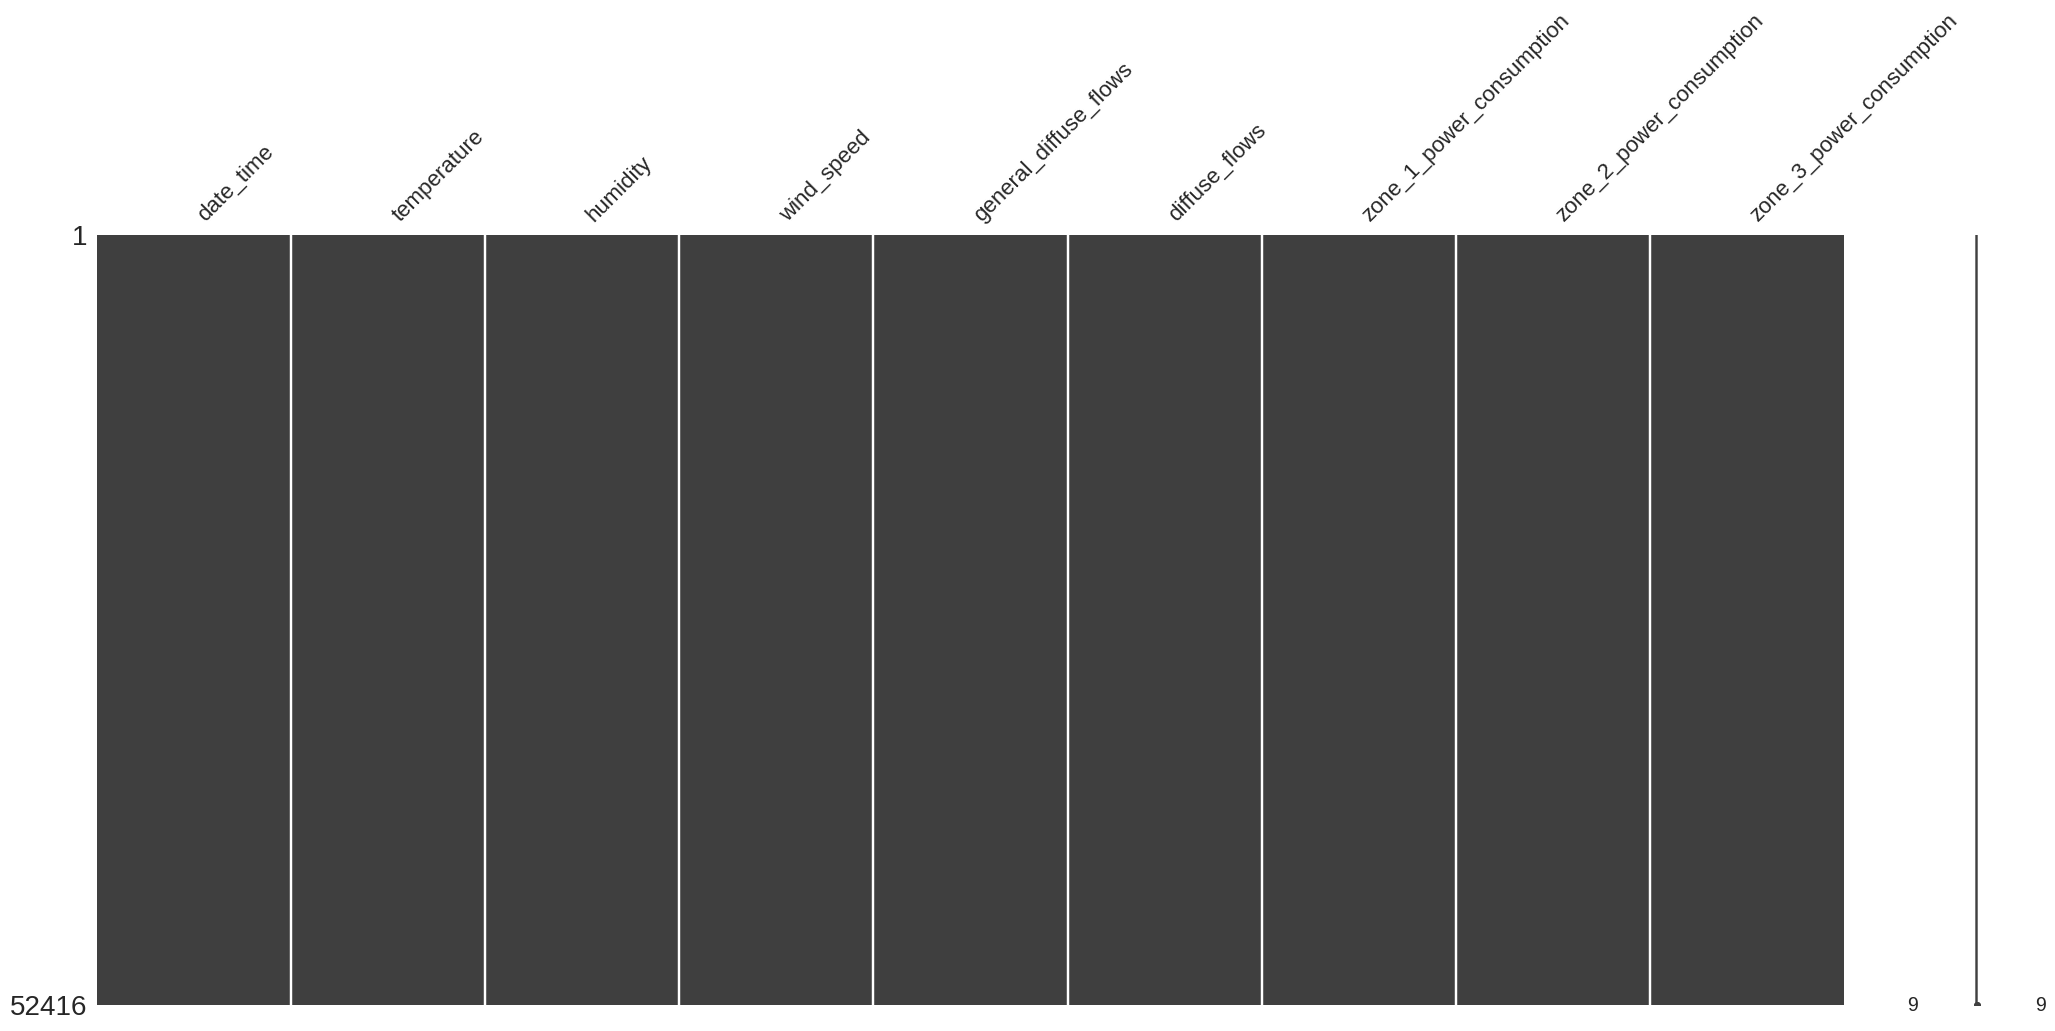

In [3]:
msno.matrix(power)

Hence, there are no missing values. Next, plot all pairs of numeric variables using the `pairplot` function.

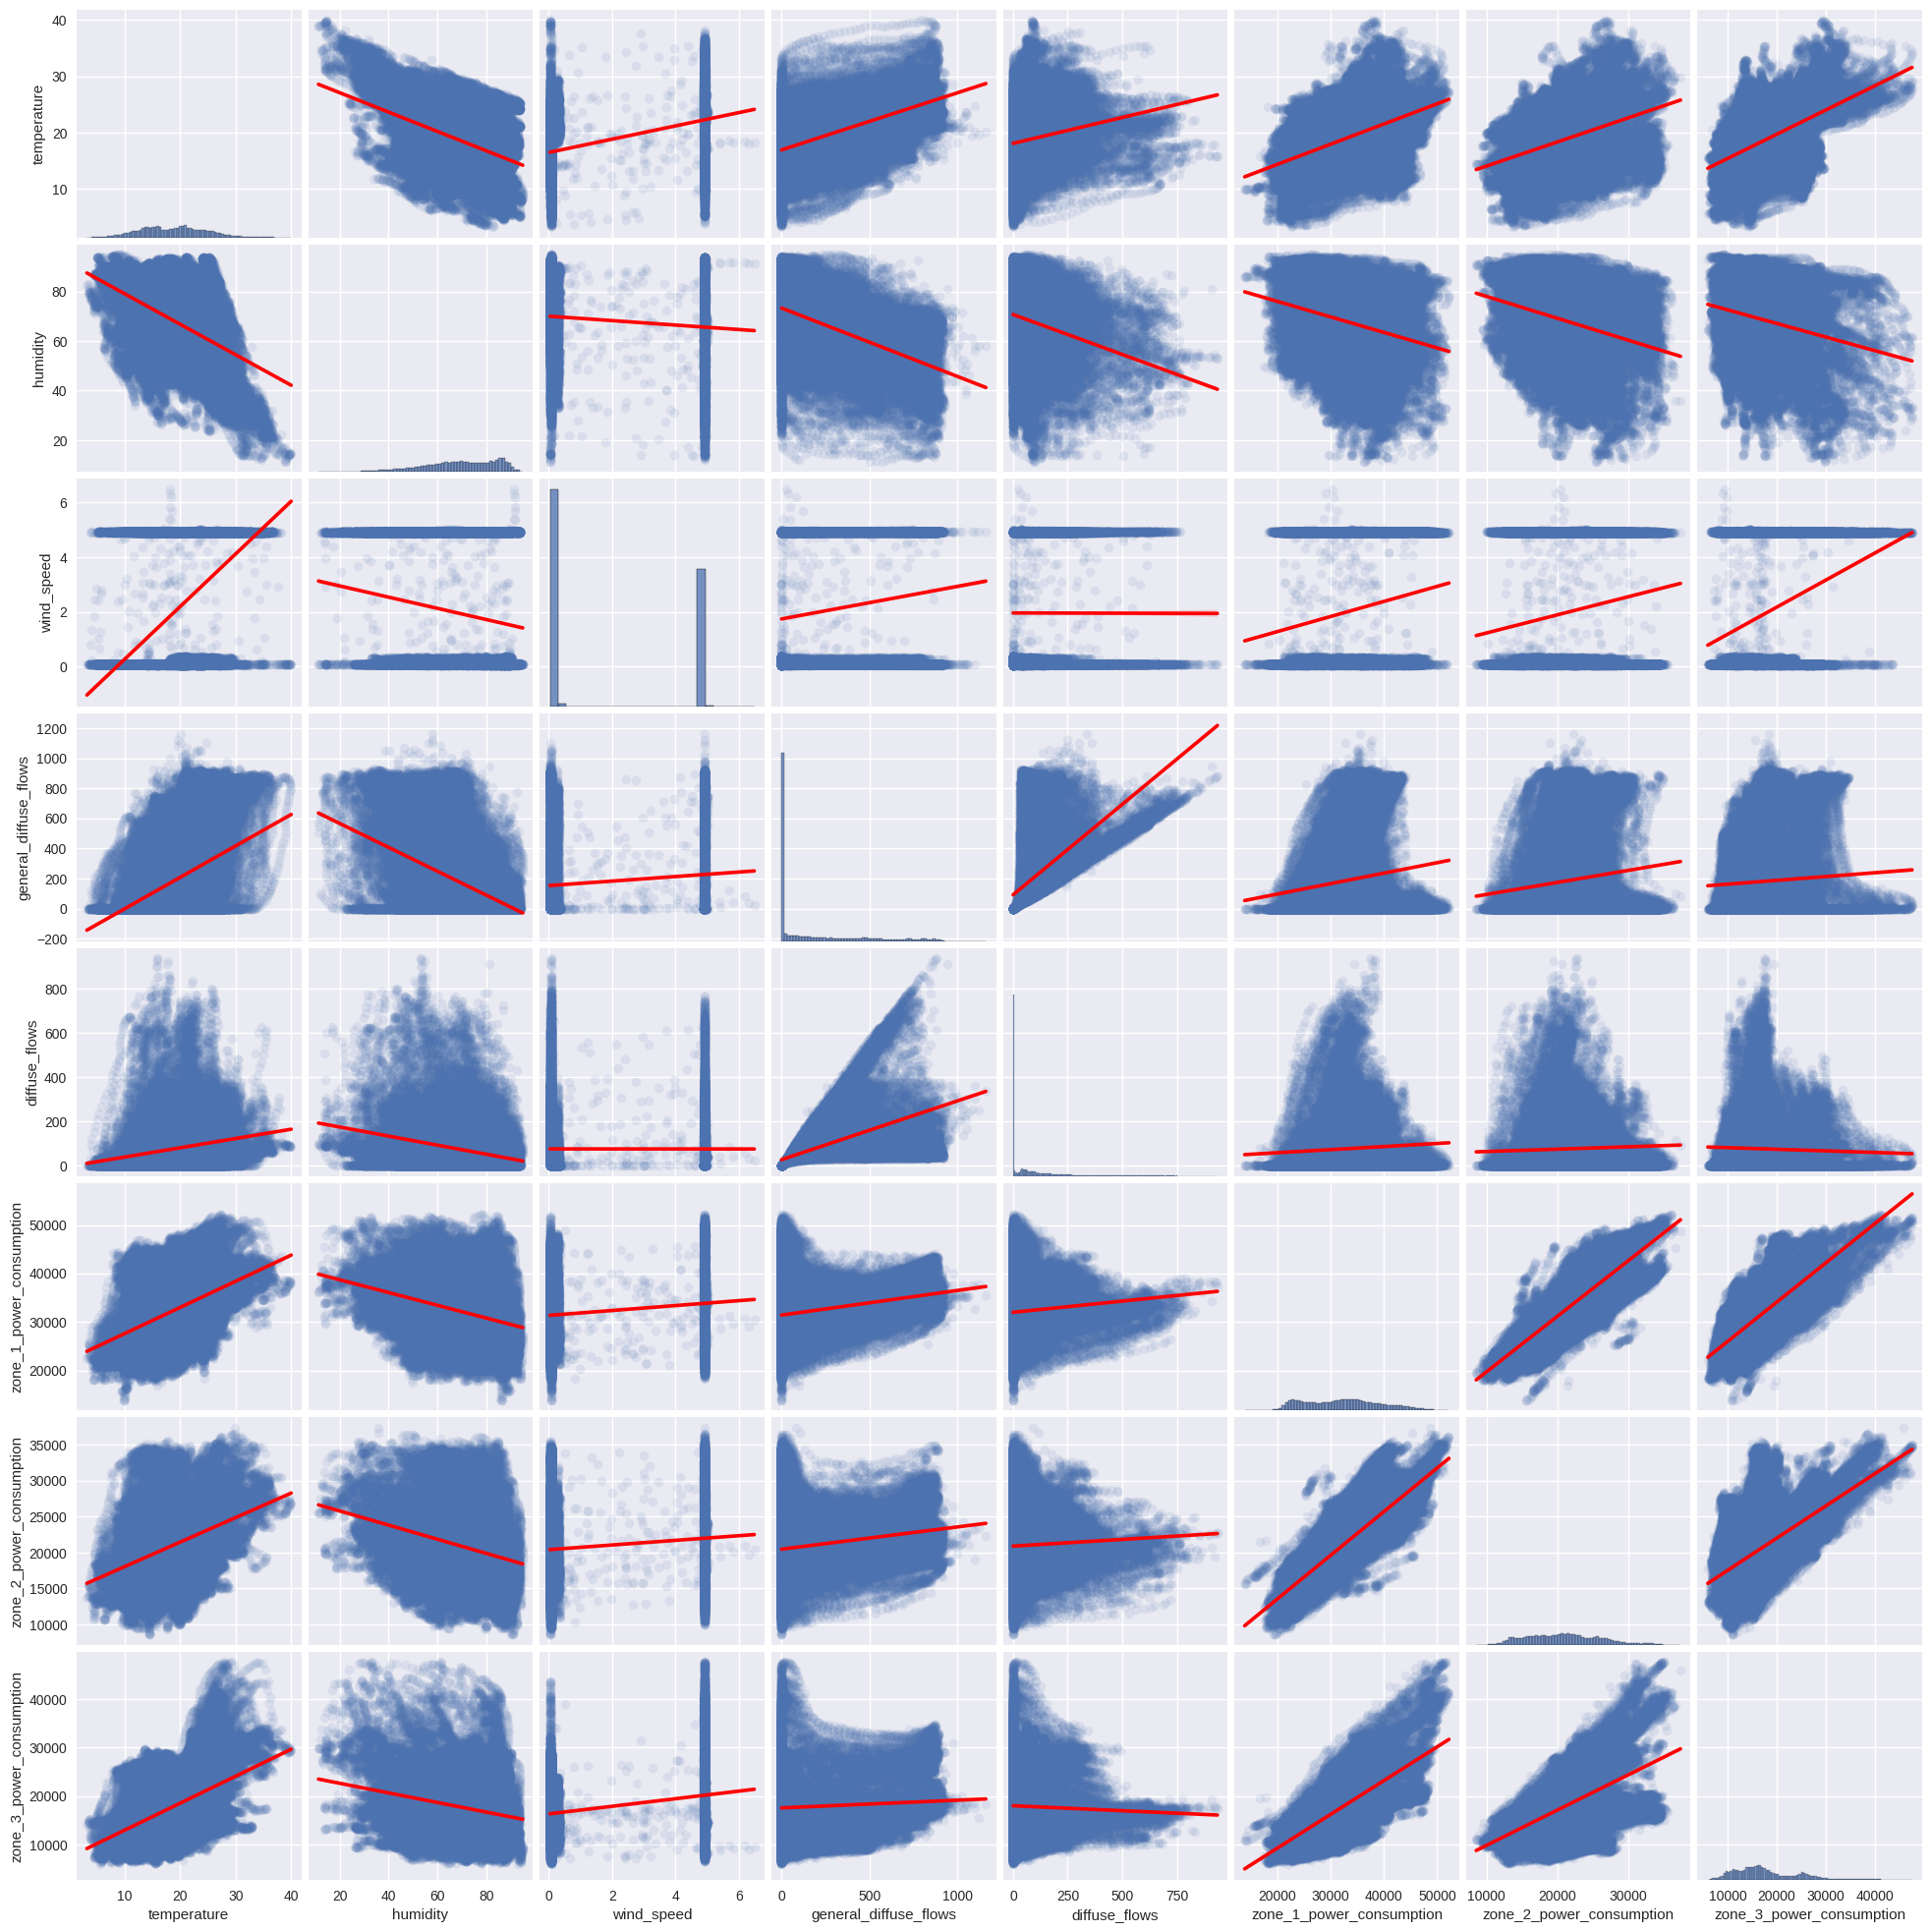

In [3]:
power_numeric = power.select_dtypes(include=np.number)
sns.pairplot(power_numeric, kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})

### Feature Engineering

In [4]:
power['date_time'] = pd.to_datetime(power['date_time'])
power['month'] = power['date_time'].dt.month
power['day'] = power['date_time'].dt.day
power['hour'] = power['date_time'].dt.hour


### Creating Data Loader

In [6]:
X = power.drop(['date_time', 'zone_1_power_consumption', 'zone_2_power_consumption', 'zone_3_power_consumption'], axis=1)
y = power['zone_1_power_consumption']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

Important note: we cannot use batch normalization in LSTM model due to the recurrent nature of these networks. Layer normalization might be worth an attempt depending on time. For now we just use standardization

In [21]:
type(X_train)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [22]:
def create_sequence(X: pd.core.frame.DataFrame, y: pd.core.frame.DataFrame, 
                    lookback_period : int) -> torch.Tensor:
    """Create a sequence of windowed input variables and target variable

    Args:
        X (pd.core.frame.DataFrame): Input variables
        y (pd.core.frame.DataFrame): Target variable
        lookback_period (int): Lookback period used for windowing

    Returns:
        torch.Tensor: Input variables and target variable as a tensor of shape (n_samples, lookback_period, n_features)
    """
    y = y.to_numpy()
    X_seq = []
    y_seq = []
    for i in range(X.shape[0] - lookback_period):
        X_seq.append(X[i:i+lookback_period])
        y_seq.append(y[i + 1:i + lookback_period + 1])
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    return torch.tensor(X_seq), torch.tensor(y_seq)

In [23]:
lookback_period = 1000
X_train_seq, y_train_seq = create_sequence(X_train, y_train, lookback_period)
print(X_train_seq.shape)
train_loader = data.DataLoader(data.TensorDataset(X_train_seq, y_train_seq), batch_size=32, shuffle=True)

torch.Size([40932, 1000, 8])


### Defining Model and Training Loop

In [15]:
# TODO: try stacked LSTM
class PowerModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PowerModel, self).__init__()
        # TODO: check if batch_first is necessary; check if dropout is necessary
        # TODO: check if bidirectional is necessary
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
    
power_model = PowerModel(X_train_seq.shape[2], 100, 1)

In [ ]:
def add_noise(x, noise_factor=0.1):
    noise = torch.randn(x.size()) * noise_factor
    noise_clamped = torch.clamp(noise, -2, 2)
    return x + noise_clamped

In [16]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_lstm_with_gaussian_noise(model, train_loader, epochs,  
                                   lr = 0.001, add_noise = True):
    optimizer = optim.Adam(model.parameters(), lr= lr )
    model = model.to(device)
    
    loss = nn.MSELoss()

    for epoch in range(epochs):
        for X, y in train_loader:
            optimizer.zero_grad()
            y_pred = model(X.float() + torch.randn(X.shape) * noise_std)
            loss = criterion(y_pred, y.float())
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch + 1} loss: {loss.item():.3f}')
    return model